# Respiratory Model Creation and Preprocessing Design

The model design portion contains references to the notebook designed by Shivam Sharma: https://www.kaggle.com/shivam316/part-3-feature-extraction-modeling-95-acc. 

A novel preprocessing step is designed at the end to process audio files without corresponding metadata to indicate important time segments. 

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa as lb
import os

In [2]:
diagnosis=pd.read_csv('/kaggle/input/respiratory-sound-database/respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv',names=['pid','disease'])
diagnosis.head()

,pid,disease
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'URTI'),
  Text(1, 0, 'Healthy'),
  Text(2, 0, 'Asthma'),
  Text(3, 0, 'COPD'),
  Text(4, 0, 'LRTI'),
  Text(5, 0, 'Bronchiectasis'),
  Text(6, 0, 'Pneumonia'),
  Text(7, 0, 'Bronchiolitis')])

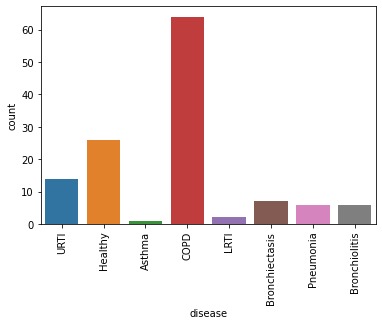

In [3]:
sns.countplot(diagnosis.disease)
plt.xticks(rotation=90)

In [4]:
def shortname(path):
    return os.path.basename(os.path.normpath(path))


def extractId(filename, full_path=False):
    return extractId(shortname(filename)) if full_path else filename.split('_')[0]

In [5]:
files_df = {}
files_df['pid'] = []
# files_df['disease'] = diagnosis['disease']
files_df['filename'] = []
i = 0
for file in os.listdir('../input/audio-data/processed_audio_files'):
    files_df['pid'].append(extractId(file))
    files_df['filename'].append(file)
files_df = pd.DataFrame(files_df)
files_df.tail()

,pid,filename
6893,122,122_2b3_Tc_mc_LittC2SE_1.wav
6894,220,220_1b2_Al_mc_LittC2SE_6.wav
6895,128,128_1b3_Tc_mc_LittC2SE_2.wav
6896,162,162_2b4_Tc_mc_AKGC417L_2.wav
6897,193,193_1b2_Al_mc_AKGC417L_1.wav


In [6]:
files_df.pid=files_df.pid.astype('int64')
data = pd.merge(files_df, diagnosis, on='pid')
data.head()

,pid,filename,disease
0,177,177_1b4_Ar_mc_AKGC417L_4.wav,COPD
1,177,177_1b4_Lr_mc_AKGC417L_2.wav,COPD
2,177,177_1b4_Ar_mc_AKGC417L_1.wav,COPD
3,177,177_2b4_Pr_mc_AKGC417L_3.wav,COPD
4,177,177_2b4_Lr_mc_AKGC417L_0.wav,COPD


In [7]:
from sklearn.model_selection import train_test_split
Xtrain,Xval,ytrain,yval=train_test_split(data,data.disease,stratify=data.disease,random_state=42,test_size=0.25)

In [8]:
Xtrain.disease.value_counts()/Xtrain.shape[0]

COPD              0.832979
Healthy           0.046588
Pneumonia         0.041369
URTI              0.035183
Bronchiolitis     0.023197
Bronchiectasis    0.015078
LRTI              0.004639
Asthma            0.000967
Name: disease, dtype: float64

In [9]:
Xval.disease.value_counts()/Xval.shape[0]

COPD              0.833043
Healthy           0.046957
Pneumonia         0.041159
URTI              0.035362
Bronchiolitis     0.023188
Bronchiectasis    0.015072
LRTI              0.004638
Asthma            0.000580
Name: disease, dtype: float64

In [10]:
Xtrain.head()

,pid,filename,disease
1436,154,154_1b3_Pl_mc_AKGC417L_9.wav,COPD
4676,159,159_1b1_Pr_sc_Meditron_8.wav,Healthy
473,170,170_1b4_Tc_mc_AKGC417L_1.wav,COPD
6397,208,208_1b1_Ll_sc_Meditron_7.wav,Healthy
1212,203,203_1p4_Al_mc_AKGC417L_2.wav,COPD


In [11]:
ytrain=Xtrain.disease
yval=Xval.disease
yval

3017    COPD
2772    COPD
825     COPD
556     COPD
4594    COPD
        ... 
1565    COPD
4494    COPD
4784    COPD
2360    COPD
1594    COPD
Name: disease, Length: 1725, dtype: object

In [12]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
ytrain=le.fit_transform(ytrain)
yval=le.transform(yval)

In [13]:
def getFeatures(path):
    soundArr,sample_rate=lb.load(path)
    mfcc=lb.feature.mfcc(y=soundArr,sr=sample_rate)
    cstft=lb.feature.chroma_stft(y=soundArr,sr=sample_rate)
    mSpec=lb.feature.melspectrogram(y=soundArr,sr=sample_rate)

    return mfcc,cstft,mSpec

In [14]:
root='../input/audio-data/processed_audio_files'
mfcc,cstft,mSpec=[],[],[]

for idx,row in Xval.iterrows():
    path= os.path.join(root, row['filename'])
    a,b,c = getFeatures(path)
    mfcc.append(a)
    cstft.append(b)
    mSpec.append(c)
    
mfcc_val=np.array(mfcc)
cstft_val=np.array(cstft)
mSpec_val=np.array(mSpec)

/opt/conda/lib/python3.7/site-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


In [15]:
mfcc,cstft,mSpec=[],[],[]

for idx,row in Xtrain.iterrows():
    path= os.path.join(root, row['filename'])
    a,b,c=getFeatures(path)
    mfcc.append(a)
    cstft.append(b)
    mSpec.append(c)
#     tone.append(d)
#     specCen.append(e)
    
mfcc_train=np.array(mfcc)
cstft_train=np.array(cstft)
mSpec_train=np.array(mSpec)

In [27]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=0.00001,mode='min')
]

In [28]:
from tensorflow import keras
mfcc_input=keras.layers.Input(shape=(20,259,1),name="mfccInput")
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(mfcc_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
mfcc_output=keras.layers.GlobalMaxPooling2D()(x)

mfcc_model=keras.Model(mfcc_input, mfcc_output, name="mfccModel")

In [29]:
mfcc_model.summary()

Model: "mfccModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mfccInput (InputLayer)       [(None, 20, 259, 1)]      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 20, 87, 32)        832       
_________________________________________________________________
batch_normalization_11 (Batc (None, 20, 87, 32)        128       
_________________________________________________________________
activation_11 (Activation)   (None, 20, 87, 32)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 10, 43, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 10, 22, 64)        18496     
_________________________________________________________________
batch_normalization_12 (Batc (None, 10, 22, 64)        25

In [30]:
croma_input=keras.layers.Input(shape=(12,259,1),name="cromaInput")
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(croma_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
croma_output=keras.layers.GlobalMaxPooling2D()(x)

croma_model=keras.Model(croma_input, croma_output, name="cromaModel")

In [31]:
croma_model.summary()


Model: "cromaModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cromaInput (InputLayer)      [(None, 12, 259, 1)]      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 12, 87, 32)        832       
_________________________________________________________________
batch_normalization_15 (Batc (None, 12, 87, 32)        128       
_________________________________________________________________
activation_15 (Activation)   (None, 12, 87, 32)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 6, 43, 32)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 6, 22, 64)         18496     
_________________________________________________________________
batch_normalization_16 (Batc (None, 6, 22, 64)         2

In [32]:
mSpec_input=keras.layers.Input(shape=(128,259,1),name="mSpecInput")
x=keras.layers.Conv2D(32,5,strides=(2,3),padding='same')(mSpec_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(2,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
mSpec_output=keras.layers.GlobalMaxPooling2D()(x)

mSpec_model=keras.Model(mSpec_input, mSpec_output, name="mSpecModel")

In [33]:
mSpec_model.summary()

Model: "mSpecModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mSpecInput (InputLayer)      [(None, 128, 259, 1)]     0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 64, 87, 32)        832       
_________________________________________________________________
batch_normalization_18 (Batc (None, 64, 87, 32)        128       
_________________________________________________________________
activation_18 (Activation)   (None, 64, 87, 32)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 43, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 16, 22, 64)        18496     
_________________________________________________________________
batch_normalization_19 (Batc (None, 16, 22, 64)        2

In [34]:
input_mfcc=keras.layers.Input(shape=(20,259,1),name="mfcc")
mfcc=mfcc_model(input_mfcc)

input_croma=keras.layers.Input(shape=(12,259,1),name="croma")
croma=croma_model(input_croma)

input_mSpec=keras.layers.Input(shape=(128,259,1),name="mspec")
mSpec=mSpec_model(input_mSpec)


concat=keras.layers.concatenate([mfcc,croma,mSpec])
hidden=keras.layers.Dropout(0.2)(concat)
hidden=keras.layers.Dense(50,activation='relu')(concat)
hidden=keras.layers.Dropout(0.3)(hidden)
hidden=keras.layers.Dense(25,activation='relu')(hidden)
hidden=keras.layers.Dropout(0.3)(hidden)
output=keras.layers.Dense(8,activation='softmax')(hidden)

net=keras.Model([input_mfcc,input_croma,input_mSpec], output, name="Net")

In [35]:
net.summary()

Model: "Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mfcc (InputLayer)               [(None, 20, 259, 1)] 0                                            
__________________________________________________________________________________________________
croma (InputLayer)              [(None, 12, 259, 1)] 0                                            
__________________________________________________________________________________________________
mspec (InputLayer)              [(None, 128, 259, 1) 0                                            
__________________________________________________________________________________________________
mfccModel (Functional)          (None, 128)          94560       mfcc[0][0]                       
________________________________________________________________________________________________

In [36]:
from keras import backend as K
net.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
K.set_value(net.optimizer.learning_rate, 0.001)

In [37]:
history=net.fit(
    {"mfcc":mfcc_train,"croma":cstft_train,"mspec":mSpec_train},
    ytrain,
    validation_data=({"mfcc":mfcc_val,"croma":cstft_val,"mspec":mSpec_val},yval),
    epochs=100,# verbose=0,
    callbacks=my_callbacks
)

Epoch 1/100
162/162 [==============================] - 8s 22ms/step - loss: 0.9073 - accuracy: 0.7360 - val_loss: 0.8719 - val_accuracy: 0.8354
Epoch 2/100
162/162 [==============================] - 3s 19ms/step - loss: 0.5325 - accuracy: 0.8272 - val_loss: 0.4245 - val_accuracy: 0.8394
Epoch 3/100
162/162 [==============================] - 3s 19ms/step - loss: 0.4660 - accuracy: 0.8428 - val_loss: 0.4036 - val_accuracy: 0.8562
Epoch 4/100
162/162 [==============================] - 3s 21ms/step - loss: 0.4404 - accuracy: 0.8450 - val_loss: 0.4080 - val_accuracy: 0.8574
Epoch 5/100
162/162 [==============================] - 3s 20ms/step - loss: 0.3801 - accuracy: 0.8543 - val_loss: 0.3414 - val_accuracy: 0.8742
Epoch 6/100
162/162 [==============================] - 3s 18ms/step - loss: 0.3573 - accuracy: 0.8655 - val_loss: 0.3310 - val_accuracy: 0.8713
Epoch 7/100
162/162 [==============================] - 3s 20ms/step - loss: 0.3702 - accuracy: 0.8641 - val_loss: 0.3368 - val_accuracy:

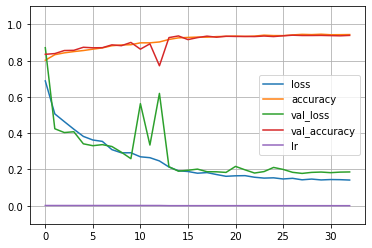

In [38]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca().set_ylim(-0.1,1.1)
plt.show()

In [39]:
net.evaluate({"mfcc":mfcc_val,"croma":cstft_val,"mspec":mSpec_val},yval)

54/54 [==============================] - 0s 6ms/step - loss: 0.1862 - accuracy: 0.9397


[0.18616582453250885, 0.9397101402282715]

In [40]:
!mkdir -p saved_model

In [41]:
net.save('saved_model/respiratory_model')

In [42]:
new_model = tf.keras.models.load_model('./saved_model/respiratory_model')